Epoch [1/20], Step [100/391], Loss: 2.0382
Epoch [1/20], Step [200/391], Loss: 1.7828
Epoch [1/20], Step [300/391], Loss: 1.6285
Epoch [1/20]:
Train Loss: 0.3568, Train Acc: 33.38%
Test Loss: 1.4139, Test Acc: 48.30%
Epoch [2/20], Step [100/391], Loss: 1.4378
Epoch [2/20], Step [200/391], Loss: 1.3744
Epoch [2/20], Step [300/391], Loss: 1.3306
Epoch [2/20]:
Train Loss: 0.3021, Train Acc: 50.04%
Test Loss: 1.2504, Test Acc: 54.59%
Epoch [3/20], Step [100/391], Loss: 1.2388
Epoch [3/20], Step [200/391], Loss: 1.2057
Epoch [3/20], Step [300/391], Loss: 1.1444
Epoch [3/20]:
Train Loss: 0.2580, Train Acc: 58.02%
Test Loss: 1.0903, Test Acc: 60.54%
Epoch [4/20], Step [100/391], Loss: 1.0663
Epoch [4/20], Step [200/391], Loss: 1.0528
Epoch [4/20], Step [300/391], Loss: 1.0214
Epoch [4/20]:
Train Loss: 0.2356, Train Acc: 63.26%
Test Loss: 0.9563, Test Acc: 66.35%
Epoch [5/20], Step [100/391], Loss: 0.9517
Epoch [5/20], Step [200/391], Loss: 0.9553
Epoch [5/20], Step [300/391], Loss: 0.9548
Epo

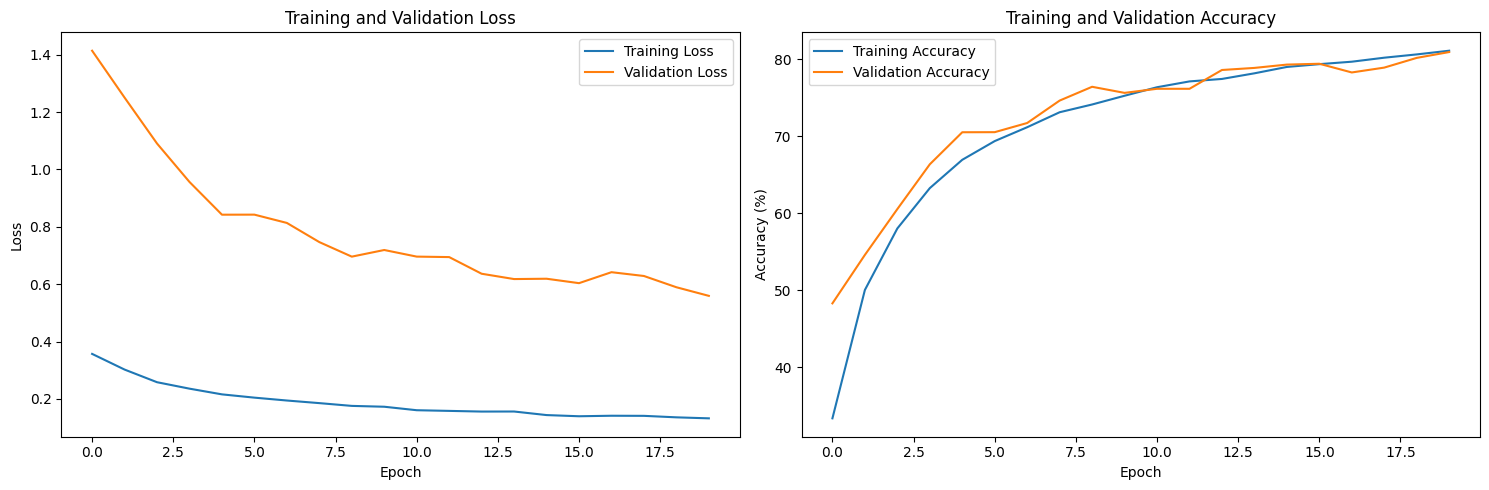

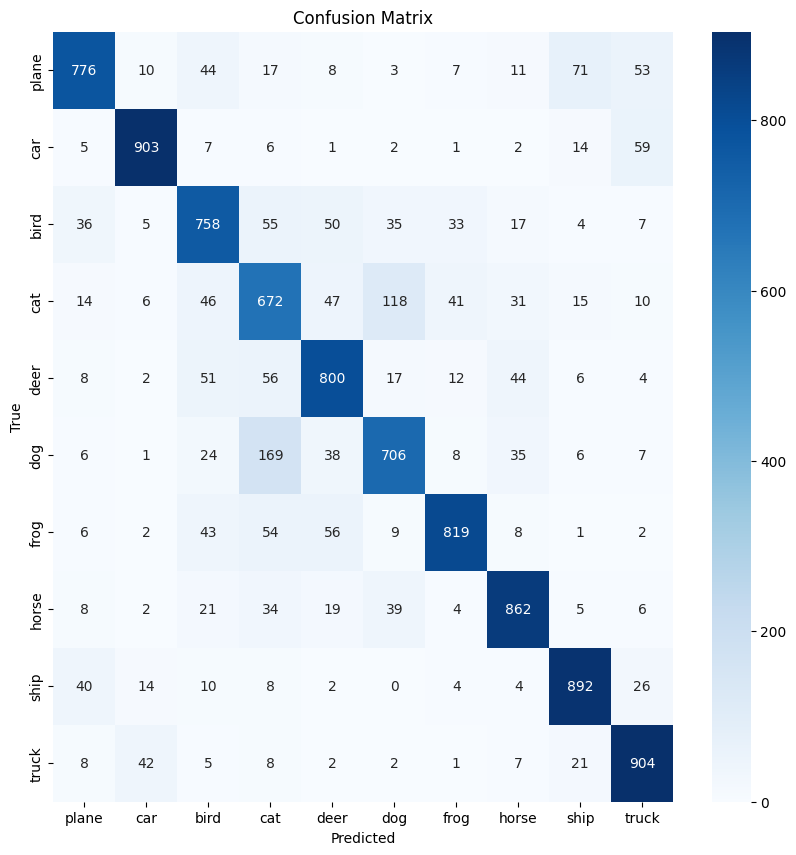

In [4]:
## AlexNet for CIFAR-10


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

#  AlexNet model adapted for CIFAR-10
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
    
    # Calculate epoch training metrics
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate epoch validation metrics
    epoch_test_loss = val_loss / len(testloader)
    epoch_test_acc = 100 * correct / total
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

print('Finished Training')

# Count and print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal number of parameters: {total_params:,}')

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params:,}')


# Plot the curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Compute and plot confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
# Calculate precision, recall, f1-score for each class
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
accuracy = accuracy_score(all_labels, all_preds)

# Print overall accuracy
print(f"\nOverall Accuracy: {accuracy*100:.2f}%\n")

# Print per-class metrics
print("Per-class metrics:")
print("Class\t\tPrecision\tRecall\t\tF1-Score")
print("-" * 60)
for i in range(len(classes)):
    print(f"{classes[i]:<12}\t{precision[i]*100:>8.2f}%\t{recall[i]*100:>8.2f}%\t{f1[i]*100:>8.2f}%")

# Print macro-averaged metrics
macro_precision = precision.mean()
macro_recall = recall.mean() 
macro_f1 = f1.mean()

print("\nMacro-averaged metrics:")
print(f"Precision: {macro_precision*100:.2f}%")
print(f"Recall: {macro_recall*100:.2f}%") 
print(f"F1-Score: {macro_f1*100:.2f}%")



Epoch [1/50], Step [100/391], Loss: 4.3987, Acc: 3.55%
Epoch [1/50], Step [200/391], Loss: 3.9365, Acc: 6.06%
Epoch [1/50], Step [300/391], Loss: 3.6848, Acc: 8.01%
Epoch [1/50] Test Accuracy: 17.03%
Epoch [2/50], Step [100/391], Loss: 3.3500, Acc: 18.34%
Epoch [2/50], Step [200/391], Loss: 3.2556, Acc: 18.97%
Epoch [2/50], Step [300/391], Loss: 3.0884, Acc: 19.90%
Epoch [2/50] Test Accuracy: 28.93%
Epoch [3/50], Step [100/391], Loss: 2.8651, Acc: 26.86%
Epoch [3/50], Step [200/391], Loss: 2.8491, Acc: 27.10%
Epoch [3/50], Step [300/391], Loss: 2.7444, Acc: 27.79%
Epoch [3/50] Test Accuracy: 30.94%
Epoch [4/50], Step [100/391], Loss: 2.5746, Acc: 33.27%
Epoch [4/50], Step [200/391], Loss: 2.5471, Acc: 33.38%
Epoch [4/50], Step [300/391], Loss: 2.4992, Acc: 33.71%
Epoch [4/50] Test Accuracy: 34.41%
Epoch [5/50], Step [100/391], Loss: 2.3609, Acc: 36.74%
Epoch [5/50], Step [200/391], Loss: 2.3617, Acc: 36.88%
Epoch [5/50], Step [300/391], Loss: 2.3202, Acc: 37.31%
Epoch [5/50] Test Accur

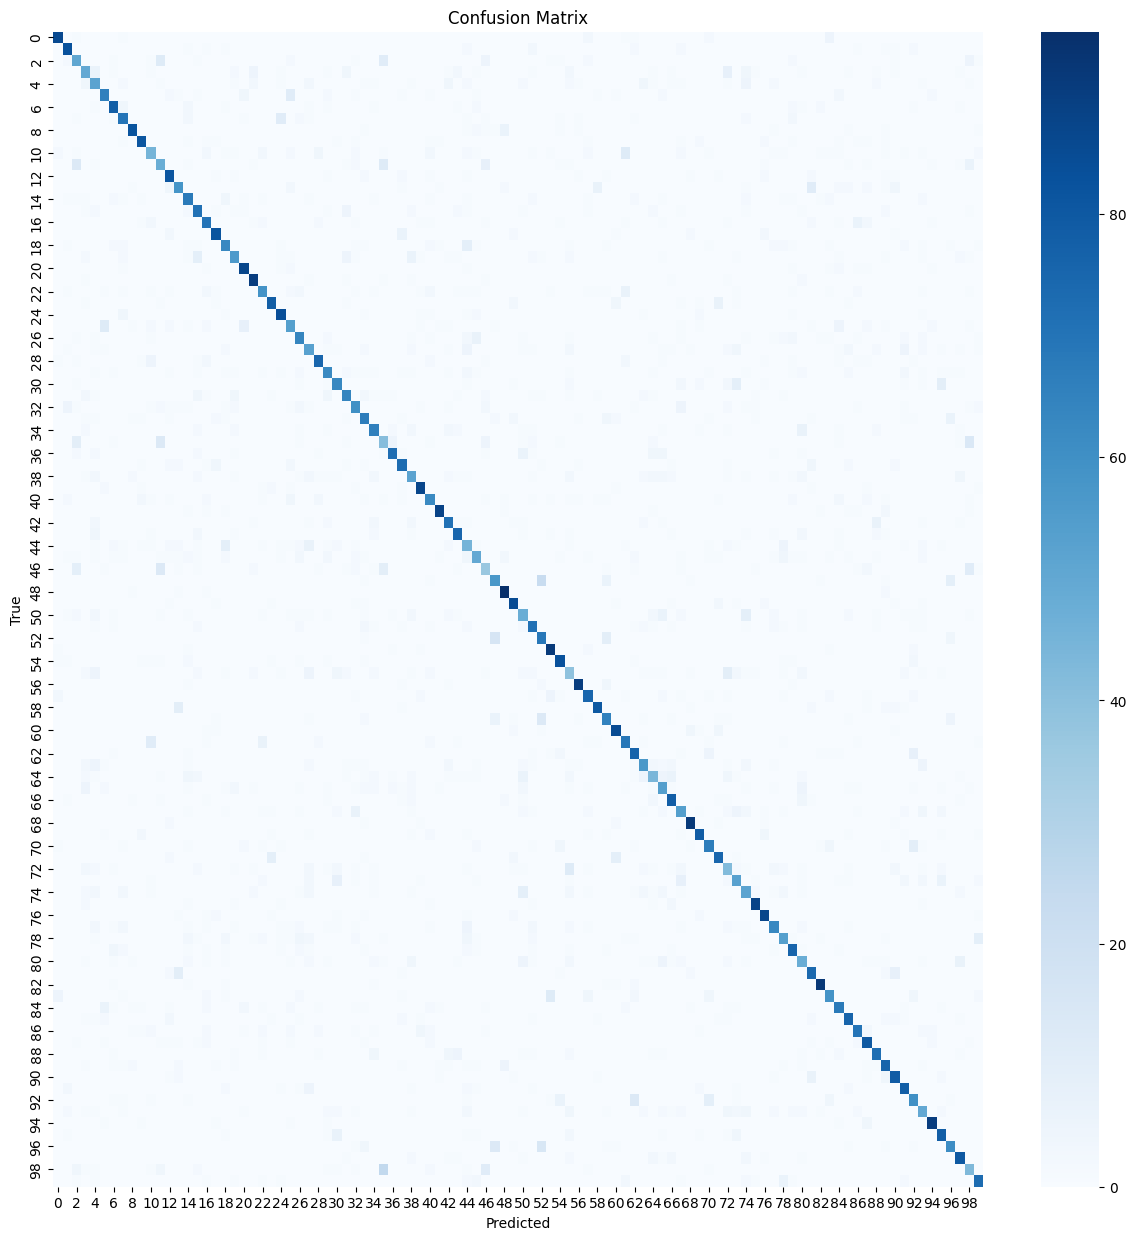

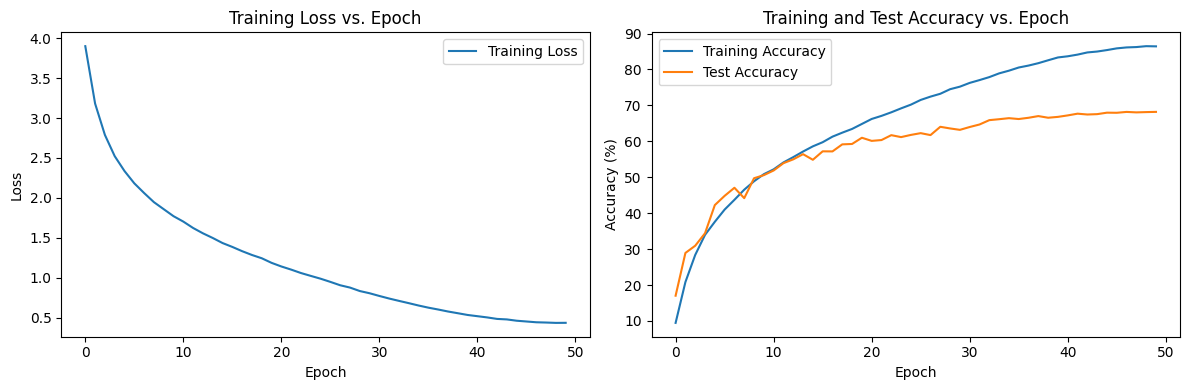

In [1]:
## CIFAR-100

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")

# AlexNet- CIFAR-100
class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1: input [3, 32, 32] -> output [64, 32, 32]
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [64, 16, 16]
            
            # Conv2: output [192, 16, 16]
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: [192, 8, 8]
            
            # Conv3: output [384, 8, 8]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            # Conv4: output [256, 8, 8]
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Conv5: output [256, 8, 8] then pool to [256, 4, 4]
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier: Adjusted for a feature map size of 4x4 after pooling.
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Data transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=100).to(device)

# Training loop
## NUM EPOCHS
num_epochs = 50 

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# lists to store metrics  -  initiate beefore training loop
train_losses = []
train_accs = []
test_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_loss = 0.0  # Track total loss for the epoch
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss += loss.item()  # Accumulate loss for the entire epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.4f}, Acc: {100*correct/total:.2f}%')
            running_loss = 0.0
            
    # Calculate and store epoch metrics
    train_losses.append(epoch_loss / len(trainloader))
    train_accs.append(100 * correct / total)
    
    # Adjust learning rate
    scheduler.step()
    
    # Evaluate on test set after each epoch
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    test_accs.append(test_acc)  # Store test accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}] Test Accuracy: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Test Accuracy: {best_acc:.2f}%')

# Compute confusion matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot the curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
